## Getting the RV distribution prior to full run

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
%matplotlib inline
import cmasher as cmr
cmap=cmr.sunburst_r

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
# this file now automatically includes the cut on magnitude (on work desktop). Should fix this for minimal confusion later
data = at.Table.read("/Users/Tavangar/Work/gd1-dr3/data/GD1-region-alldata.fits")

In [4]:
# pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

# run_sel = pm_mask & (iso_mask | hb_mask)
# run_data_ = iso_obj.cat[run_sel]
# stream_sel0 = pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask
# stream_data0 = iso_obj.cat[stream_sel0]
# def f(x,a,b):
#     return a*x+b
# popt,_ = curve_fit(f, np.array(stream_data0['phi1'][~np.isnan(stream_data0['rv']).mask]), np.array(stream_data0['rv'][~np.isnan(stream_data0['rv']).mask]))
# stream_sel = stream_sel0 & ((np.isnan(iso_obj.cat['rv'])) | (np.abs(iso_obj.cat['rv'] - f(iso_obj.cat['phi1'], *popt)) < 100))
# stream_data_ = iso_obj.cat[stream_sel]

# bkg_data_ = iso_obj.cat[run_sel & ~stream_sel]

# post_cats = {'run_data': run_data_,
#          'bkg_data': bkg_data_,
#          'stream_data': stream_data_,
#          'pawprint': pawprint,
#          'iso_obj': iso_obj}
# with open('../../data/post_cats_data.pkl', 'wb') as param_file:
#     pickle.dump(post_cats, param_file)

with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [5]:
bkg_data0_ = bkg_data_[~np.isnan(bkg_data_['rv'])]
stream_data0_ = stream_data_[~np.isnan(stream_data_['rv'])]
run_data0_ = run_data_[~np.isnan(run_data_['rv'])]

In [6]:
only_rv_run_data = {k: jnp.array(run_data0_[k], dtype="f8") for k in ['phi1','rv']}
only_rv_bkg_data = {k: jnp.array(bkg_data0_[k], dtype="f8") for k in ['phi1','rv']}
only_rv_stream_data = {k: jnp.array(stream_data0_[k], dtype="f8") for k in ['phi1','rv']}

# Fill in rv data for rows without it (rv=0, rv_err=1e4)
# run_data_['rv'][run_data_['rv'].mask] = 0
# run_data_['rv_err'][run_data_['rv_err'].mask] = 1e4

# bkg_data_['rv'][bkg_data_['rv'].mask] = 0
# bkg_data_['rv_err'][bkg_data_['rv_err'].mask] = 1e4

# stream_data_['rv'][stream_data_['rv'].mask] = 0
# stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

In [7]:
run_data = {k: jnp.array(run_data0_[k], dtype="f8") for k in ['phi1', 'rv']}#run_data_.colnames}
run_data_err = {'rv': jnp.array(run_data0_['rv_err'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data0_[k], dtype="f8") for k in ['phi1', 'rv']}#bkg_data_.colnames}
bkg_data_err = {'rv': jnp.array(bkg_data0_['rv_err'], dtype="f8")}

stream_data = {k: jnp.array(stream_data0_[k], dtype="f8") for k in ['phi1','rv']}#stream_data_.colnames}
stream_data_err = {'rv': jnp.array(stream_data0_['rv_err'], dtype="f8")}


# stream_data_['rv'][stream_data_['rv'].mask] = 0
# stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

# stream_data_all = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1','rv']}#stream_data_.colnames}
# stream_data_err_all = {'rv': jnp.array(stream_data_['rv_err'], dtype="f8")}

In [8]:
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)

pm_poly = iso_obj.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, facecolor="cyan", alpha=0.15)

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(iso_obj.cat["phi1"]) - iso_obj.dist_mod

In [22]:
phi1_lim = (jnp.min(run_data_['phi1']), jnp.max(run_data_['phi1']))
# phi2_lim = (jnp.min(data['phi2']), jnp.max(data['phi2']))
# pm1_lim = (jnp.min(pawprint.pmprint.vertices[:,0]), jnp.max(pawprint.pmprint.vertices[:,0]))
# pm2_lim = (jnp.min(pawprint.pmprint.vertices[:,1]), jnp.max(pawprint.pmprint.vertices[:,1]))
rv_lim = (jnp.min(run_data_['rv']), jnp.max(run_data_['rv']))
plot_grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "rv": jnp.linspace(*rv_lim, 128)
}

In [23]:
bkg_knot_spacings    = jnp.array([40,40])
stream_knot_spacings = jnp.array([5,10])

## Background

In [41]:
phi1_knot_spacing, rv_knot_spacing = bkg_knot_spacings

bkg_phi1_knots = jnp.arange(jnp.around(phi1_lim[0]),# + phi1_knot_spacing/2, 
                            jnp.around(phi1_lim[1])+1e-3,# - phi1_knot_spacing/2 + 1e-3, 
                            phi1_knot_spacing)
bkg_rv_knots   = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, rv_knot_spacing)

n_mixture=2
bkg_model = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": IndependentGMM,
        "rv": TruncatedNormal1DSplineMixture,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(bkg_phi1_knots))),
            ),
            "locs": bkg_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([bkg_phi1_knots.shape[0]]),
            "low":  jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],                  
        },
        "rv": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_rv_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-500, high=500).expand([n_mixture, bkg_rv_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=100,scale=100,low=0.1).expand([n_mixture, bkg_rv_knots.shape[0]]),
            "knots": bkg_rv_knots,
            "x": bkg_data["phi1"],
            "low": -500, #rv_lim[0],
            "high": 500, #rv_lim[1],
            "spline_k": 3,
            "clip_locs": (-500, 500),
            "clip_scales": (0.1, None),
        },
    },
    conditional_data={"rv": {"x": "phi1"}},
)

In [42]:
n_phi1_knots = bkg_model.coord_parameters['phi1']['locs'].shape[-1]
n_rv_knots = bkg_model.coord_parameters['rv']['knots'].shape[-1]
bkg_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(n_phi1_knots) / n_phi1_knots,
        "scales": jnp.full(n_phi1_knots, bkg_knot_spacings[0])
    },
    "rv": {
            "mixing_distribution": jnp.ones(n_mixture) / n_mixture,
            "loc_vals": jnp.full((n_mixture, n_rv_knots), -100),
            "scale_vals": jnp.full((n_mixture,n_rv_knots), 50),
        },

}

In [43]:
bkg_frozen_params = {}
# Parameter grouping
def bkg_param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in bkg_frozen_params else "trainable"
    return labels

In [85]:
keys=jax.random.split(jax.random.PRNGKey(1234), num=2)
init_lr = 1e-1
num_steps = 2_000

# Define step intervals
eighth_steps = num_steps // 8
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=500, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=500, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=500, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=500, alpha=1e-1),
        ],
        boundaries=[500, 
                    1000,
                    1500,
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
# trainable_optimizer = optax.chain(optax.clip(10),
#                                 optax.adam(learning_rate=5e-2)
#                                 )

bkg_masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    bkg_param_labels
)

# Convert to NumPyro optimizer
bkg_optimizer = numpyro.optim.optax_to_numpyro(bkg_masked_optimizer)
bkg_guide = AutoDelta(
        bkg_model, init_loc_fn=numpyro.infer.init_to_value(values=bkg_init_params)
    )
svi = SVI(bkg_model, bkg_guide, bkg_optimizer, Trace_ELBO(num_particles=5))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    bkg_init_state = svi.init(keys[0], init_params=bkg_init_params, data=bkg_data, err=bkg_data_err)
    print(svi.evaluate(bkg_init_state, data=bkg_data, err=bkg_data_err))

1140293860.2202299


In [86]:
bkg_svi_results = svi.run(
        rng_key=keys[1], num_steps=2_000, init_state=bkg_init_state, 
        data=bkg_data, err=bkg_data_err
    )

100%|█████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.98it/s, init loss: 1140293860.2202, avg. loss [1901-2000]: 102397.2861]


In [87]:
bkg_svi_results.params

{'background:phi1:mixing_distribution_auto_loc': Array([5.63240760e-05, 2.85083626e-01, 7.13217314e-01, 1.64273561e-03],      dtype=float64),
 'background:phi1:scales_auto_loc': Array([22.61746478, 13.36268454, 16.96421807, 18.6402778 ], dtype=float64),
 'background:rv:loc_vals_auto_loc': Array([[ 280.72147877,  224.04469914,   41.81044977,  -34.78093172],
        [ 122.28779893,   37.61790988,  -30.92769153, -148.18628075]],      dtype=float64),
 'background:rv:mixing_distribution_auto_loc': Array([0.36358045, 0.63641955], dtype=float64),
 'background:rv:modeldata_auto_loc': Array([ 15.38728334, 297.76724409, 118.08180962, ...,   9.79853389,
        154.92032632, 148.37617194], dtype=float64),
 'background:rv:scale_vals_auto_loc': Array([[ 97.81328256,  70.73502389,  80.64658666,  16.0518733 ],
        [ 42.33988393,   3.22071185,  68.08171853, 116.46556422]],      dtype=float64)}

102397.28558744783


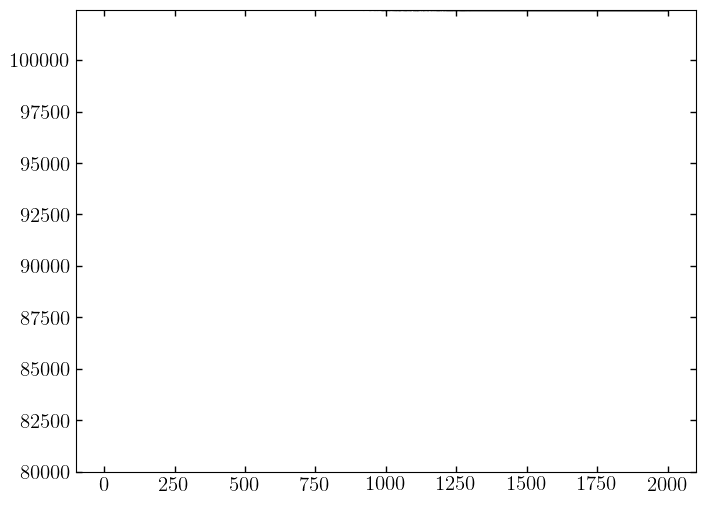

In [88]:
print(bkg_svi_results.losses[-1])
plt.plot(bkg_svi_results.losses, lw=1)
plt.ylim(0.8e5, 1.0245e5)
# plt.yscale('log')

plt.show()

In [89]:
bkg_params = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                            guide=bkg_guide, num_samples=1, key=jax.random.PRNGKey(12345))

In [90]:
plot_grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "rv": jnp.linspace(-500,500, 128)
}

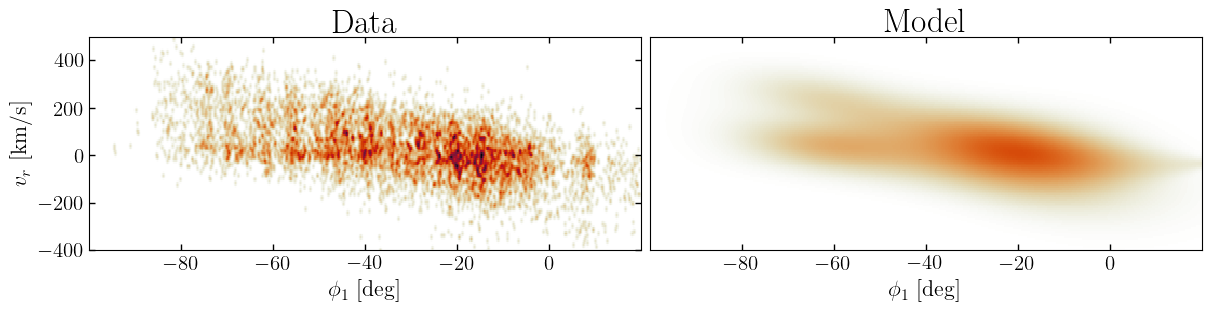

In [91]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)

plot_data_projections(
    data=bkg_data0_,
    grids=plot_grids,
    axes=ax1,
    pcolormesh_kwargs=dict(rasterized=True, vmax=2, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

bkg_model.plot_model_projections(ndata=len(bkg_data0_['rv'][bkg_data0_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'rv')],
                          pars=bkg_params, axes=ax2, label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=2, vmin=0, cmap=cmap))


ax2.yaxis.set_visible(False)
ax2.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)

# plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

(-500.0, 500.0)

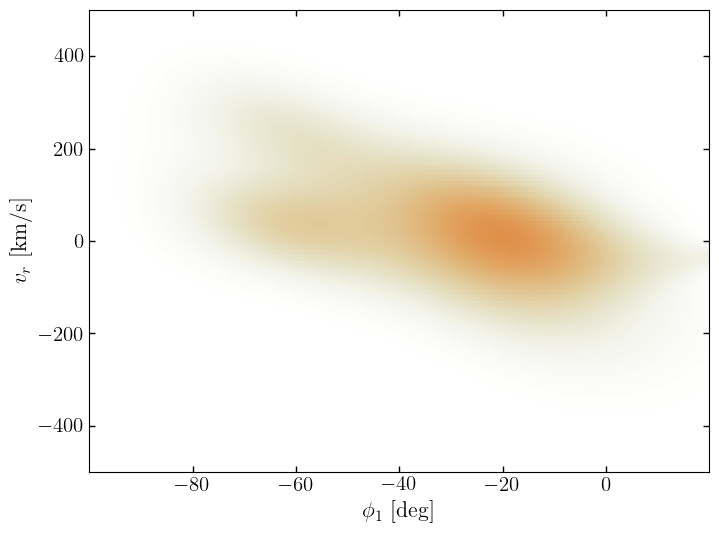

In [92]:
fig, ax = plt.subplots(1,1)
bkg_model.plot_model_projections(ndata=len(bkg_data0_['rv'][bkg_data0_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'rv')],
                          pars=bkg_params,label=True, axes=ax,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
ax.set_ylim(-500,500)

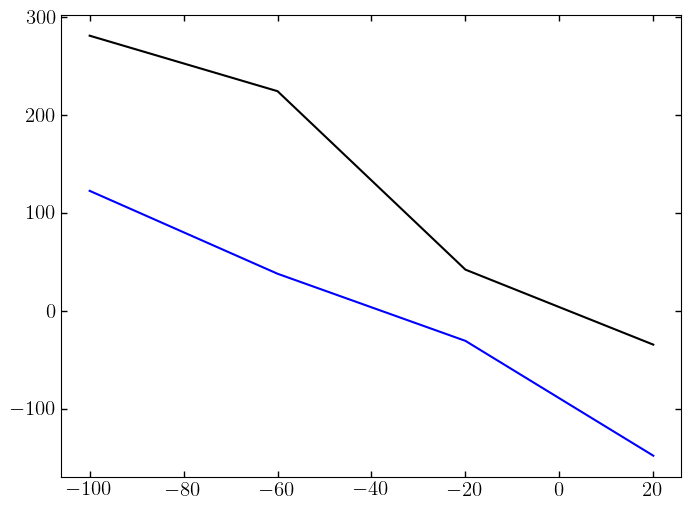

In [93]:
plt.plot(bkg_rv_knots, bkg_params['rv']['loc_vals'][0])
plt.plot(bkg_rv_knots, bkg_params['rv']['loc_vals'][1])
plt.show()

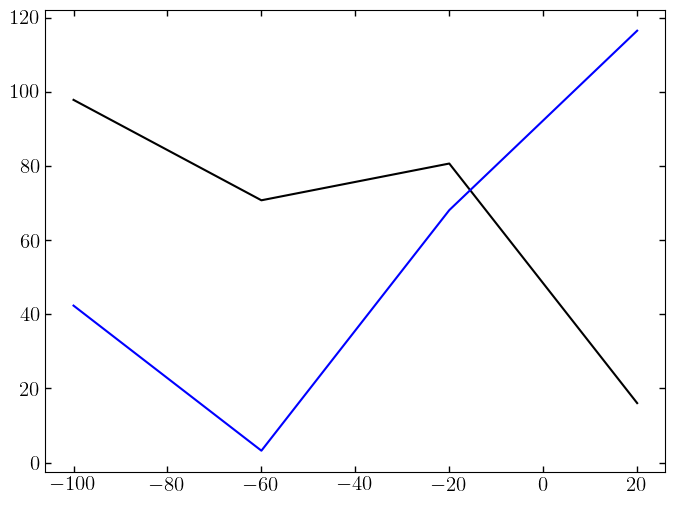

In [94]:
plt.plot(bkg_rv_knots, bkg_params['rv']['scale_vals'][0])
plt.plot(bkg_rv_knots, bkg_params['rv']['scale_vals'][1])
plt.show()

## Stream

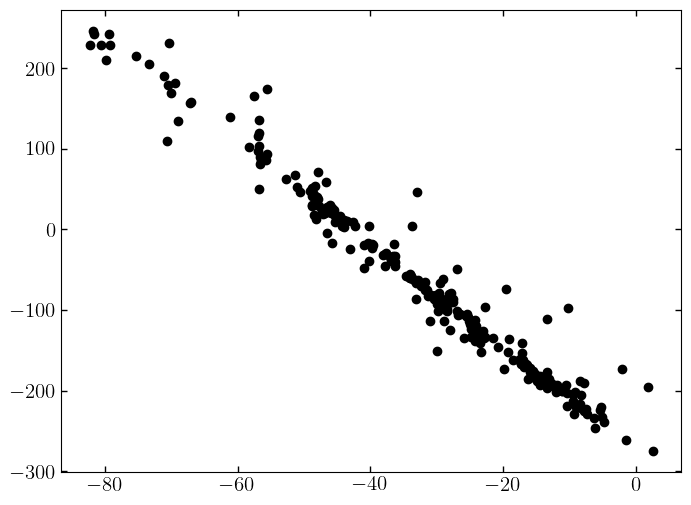

In [95]:
plt.scatter(stream_data['phi1'], stream_data['rv'])
plt.show()

In [202]:
from scipy.stats import binned_statistic
phi1_knot_spacing, rv_knot_spacing = stream_knot_spacings

stream_phi1_knots = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, phi1_knot_spacing)
stream_rv_knots  = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, rv_knot_spacing)

_rv_stat = binned_statistic(stream_data["phi1"], stream_data["rv"], bins=jnp.linspace(np.min(stream_data['phi1']), np.max(stream_data['phi1']), 16))
_rv_interp = IUS(
    0.5 * (_rv_stat.bin_edges[:-1] + _rv_stat.bin_edges[1:]), _rv_stat.statistic, ext=0, k=3
)

_interp_dict = {'rv': _rv_interp}

eval_interp_rv = jnp.array(_interp_dict['rv'](stream_rv_knots))

stream_model = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "rv": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([stream_phi1_knots.shape[0]]),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "rv": {
            # "loc_vals": dist.Uniform(*rv_lim).expand([stream_rv_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_rv, scale=200, low=-500,high=500).expand([stream_rv_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=1,scale=5,low=0.1, high=20).expand([stream_rv_knots.shape[0]]),
            "knots": stream_rv_knots,
            "x": stream_data["phi1"],
            "low": -500, #rv_lim[0],
            "high": 500, #rv_lim[1],
            "spline_k": 3,
            "clip_locs": (-500,500), #rv_lim,
            "clip_scales": (0.1, 20),
        },
    },
    conditional_data={"rv": {"x": "phi1"}}
)

In [203]:
stream_init_params = {
        "phi1": {
            "mixing_distribution": jnp.ones(len(stream_phi1_knots))
            / len(stream_phi1_knots),
            "scales": jnp.full(stream_phi1_knots.shape[0], stream_knot_spacings[0]),
        },
        "rv": {
            "loc_vals": eval_interp_rv,
            "scale_vals": jnp.full(stream_rv_knots.shape[0], 4),
        },
    }

In [204]:
stream_frozen_params = {}
# Parameter grouping
def stream_param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in bkg_frozen_params else "trainable"
    return labels

In [205]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 1e-1
num_steps = 2_000

# Define step intervals
eighth_steps = num_steps // 8
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=25000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=25000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=25000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=25000, alpha=1e-1),
        ],
        boundaries=[25000, 
                    50000,
                    75000,
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
# trainable_optimizer = optax.chain(optax.clip(10),
#                                 optax.adam(learning_rate=5e-2)
#                                 )

stream_masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    stream_param_labels
)

# Convert to NumPyro optimizer
stream_optimizer = numpyro.optim.optax_to_numpyro(stream_masked_optimizer)
stream_guide = AutoDelta(
        stream_model, init_loc_fn=numpyro.infer.init_to_value(values=stream_init_params)
    )
svi = SVI(stream_model, stream_guide, stream_optimizer, Trace_ELBO(num_particles=5))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    stream_init_state = svi.init(keys[0], init_params=stream_init_params, data=stream_data, err=stream_data_err)
    print(svi.evaluate(stream_init_state, data=stream_data, err=stream_data_err))

156960825.9228101


In [206]:
stream_svi_results = svi.run(
        rng_key=keys[1], num_steps=100_000, init_state=stream_init_state, 
        data=stream_data, err=stream_data_err
    )

100%|████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2699.23it/s, init loss: 156960825.9228, avg. loss [95001-100000]: 3236.3564]


3236.4117329203173


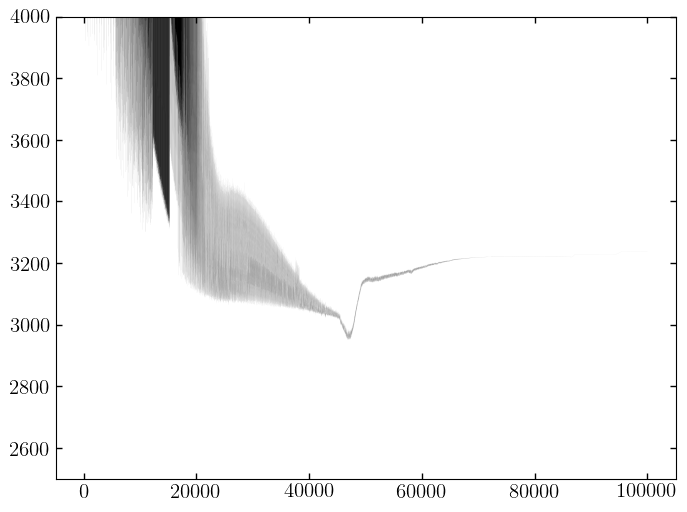

In [207]:
print(stream_svi_results.losses[-1])
plt.plot(stream_svi_results.losses, lw=.01)
plt.ylim(2.5e3, 4e3)
# plt.yscale('log')

plt.show()

In [208]:
stream_params = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                            guide=stream_guide, num_samples=1, key=jax.random.PRNGKey(12345))

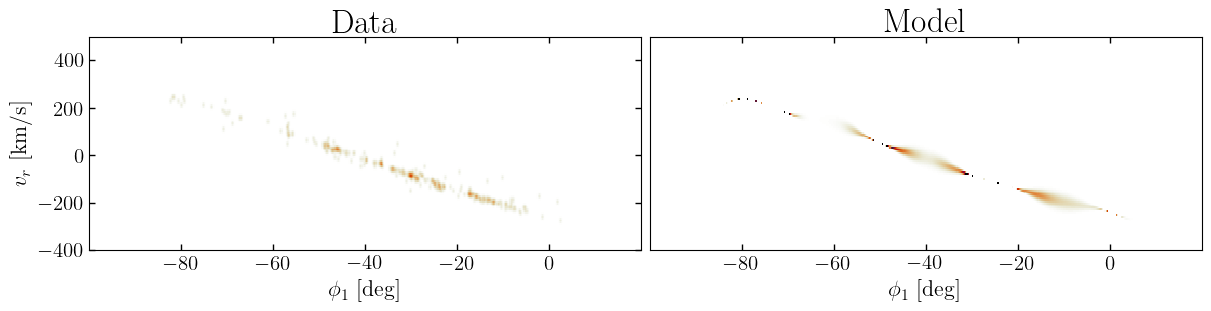

In [209]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)

plot_data_projections(
    data=only_rv_stream_data,
    grids=plot_grids,
    axes=ax1,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

stream_model.plot_model_projections(ndata=len(stream_data), grids=plot_grids, grid_coord_names=[('phi1', 'rv')],
                          pars=stream_params, axes=ax2, label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=0.01, vmin=0, cmap=cmap))


ax2.yaxis.set_visible(False)
ax2.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)

# plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

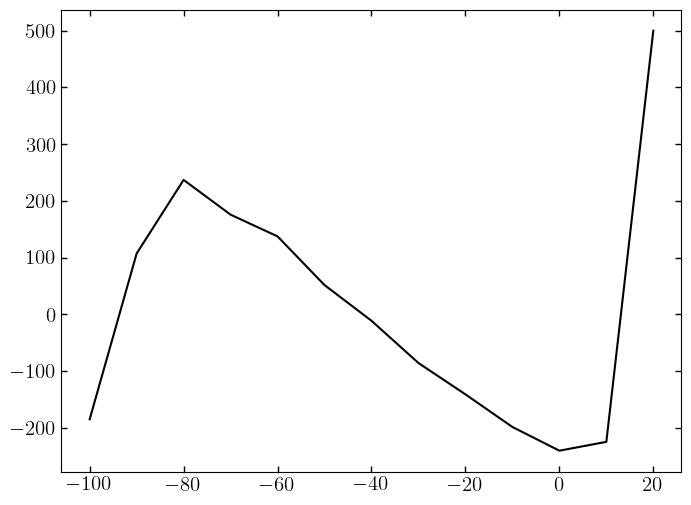

In [210]:
plt.plot(stream_rv_knots, stream_params['rv']['loc_vals'])
plt.show()

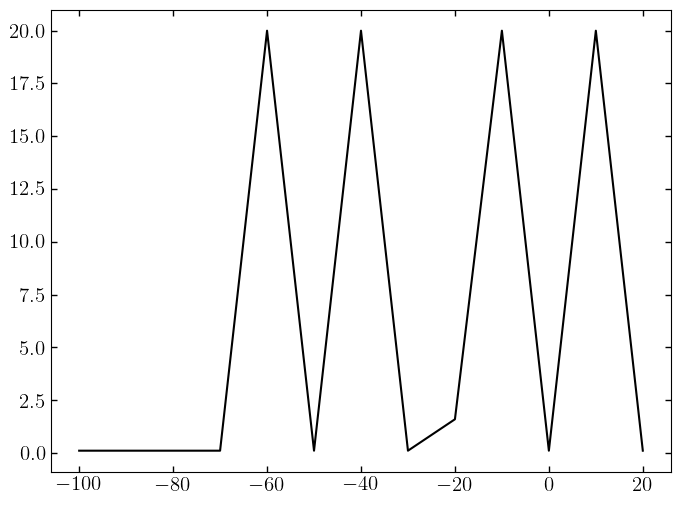

In [211]:
plt.plot(stream_rv_knots, stream_params['rv']['scale_vals'])
plt.show()

## Stream+Background

In [201]:
bkg_model_mm = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": IndependentGMM,
        "rv": TruncatedNormal1DSplineMixture,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(bkg_phi1_knots))),
            ),
            "locs": bkg_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([bkg_phi1_knots.shape[0]]),
            "low":  jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],                  
        },
        "rv": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_rv_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-500, high=500).expand([n_mixture, bkg_rv_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=100,scale=100,low=0.1).expand([n_mixture, bkg_rv_knots.shape[0]]),
            "knots": bkg_rv_knots,
            "x": run_data["phi1"],
            "low": -500, #rv_lim[0],
            "high": 500, #rv_lim[1],
            "spline_k": 3,
            "clip_locs": (-500, 500),
            "clip_scales": (0.1, None),
        },
    },
    conditional_data={"rv": {"x": "phi1"}},
)

stream_model_mm = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "rv": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([stream_phi1_knots.shape[0]]),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "rv": {
            # "loc_vals": dist.Uniform(*rv_lim).expand([stream_rv_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_rv, scale=200, low=-500,high=500).expand([stream_rv_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=1,scale=5,low=0.1, high=20).expand([stream_rv_knots.shape[0]]),
            "knots": stream_rv_knots,
            "x": run_data["phi1"],
            "low": -500, #rv_lim[0],
            "high": 500, #rv_lim[1],
            "spline_k": 1,
            "clip_locs": (-500,500), #rv_lim,
            "clip_scales": (0.1, 20),
        },
    },
    conditional_data={"rv": {"x": "phi1"}}
)

stream_bkg_mm = ComponentMixtureModel(dist.Dirichlet(jnp.array([1.0, 1.0])), 
                                          components=[bkg_model_mm, stream_model_mm])


In [154]:
init_params ={}#= bkg_svi_results.params | stream_svi_results.params

In [185]:
init_params = stream_bkg_svi_results.params

In [186]:
stream_bkg_frozen_params = {}

# Parameter grouping
def stream_bkg_param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in stream_bkg_frozen_params else "trainable"
    return labels

In [187]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 1e-1
num_steps=10_000

# stream_bkg_optimizer = numpyro.optim.ClippedAdam(1e-2)

# Define the base optimizer
# base_optimizer = optax.adam(learning_rate=init_lr)

# Define step intervals
fiftieth_steps = num_steps // 50
tenth_steps = num_steps // 10
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=2500, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=6000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=6000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=5500, alpha=1e-1),
        ],
        boundaries=[2500, 
                    8500,
                    14500
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=5e-6)
                                )


# # Combine with `optax.masked`
# masked_optimizer = optax.chain(optax.clip(10.),
#                                optax.masked(optax.adam(learning_rate=lr_schedule), mask_fn),  # Mask updates for frozen parameters
#                                optax.set_to_zero()  # Explicitly zero out gradients for masked parameters
# )
# Combine optimizers using multi_transform
masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    stream_bkg_param_labels
)

# Convert to NumPyro optimizer
stream_bkg_optimizer = numpyro.optim.optax_to_numpyro(masked_optimizer)

stream_bkg_guide = AutoDelta(
        stream_bkg_mm, init_loc_fn=numpyro.infer.init_to_value(values=init_params)
    )
stream_bkg_svi = SVI(stream_bkg_mm, stream_bkg_guide, stream_bkg_optimizer, Trace_ELBO(num_particles=3))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    stream_bkg_init_state = stream_bkg_svi.init(keys[0], init_params=init_params, data=run_data, err=run_data_err)
    print(stream_bkg_svi.evaluate(stream_bkg_init_state, data=run_data, err=run_data_err))

44114.91567285741


In [188]:
stream_bkg_svi_results = stream_bkg_svi.run(
            rng_key=keys[1], num_steps=1_000, init_state=stream_bkg_init_state, 
            data=run_data, err=run_data_err
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.43it/s, init loss: 44114.9157, avg. loss [951-1000]: 43744.3969]


In [171]:
stream_bkg_svi_results = stream_bkg_svi.run(
            rng_key=keys[1], num_steps=1_000, init_state=stream_bkg_svi_results.state, 
            data=run_data, err=run_data_err
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.94it/s, init loss: 44104.8936, avg. loss [951-1000]: 44092.8825]


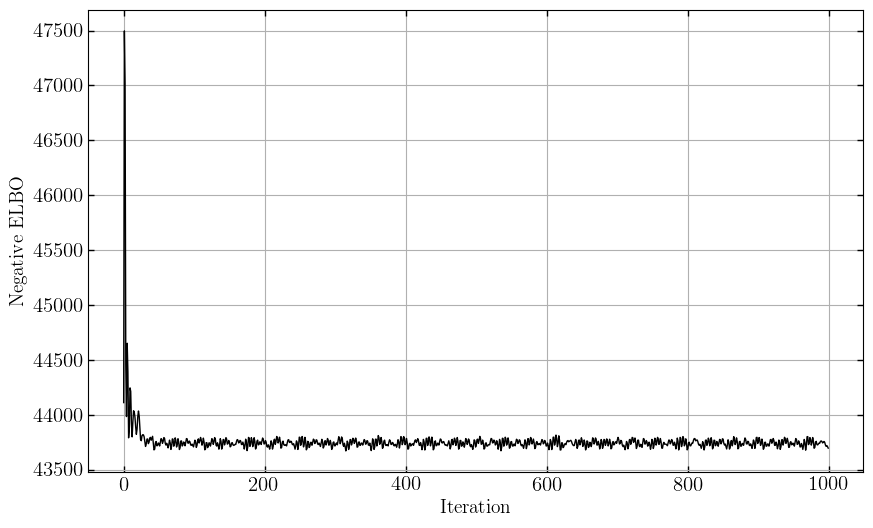

In [189]:
plt.figure(figsize=(10,6))
plt.plot(stream_bkg_svi_results.losses, lw=1)
# plt.ylim(4e4, 7e4) #; plt.xlim(40000,50000)
# plt.yscale('log')
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

In [190]:
MAP_p_expanded = get_svi_params(stream_bkg_mm, run_data, stream_bkg_svi_results, stream_bkg_guide, 
                                num_samples=1, key=jax.random.PRNGKey(42))

In [191]:
print(MAP_p_expanded['mixture-probs'])

[0.95386118 0.04613882]


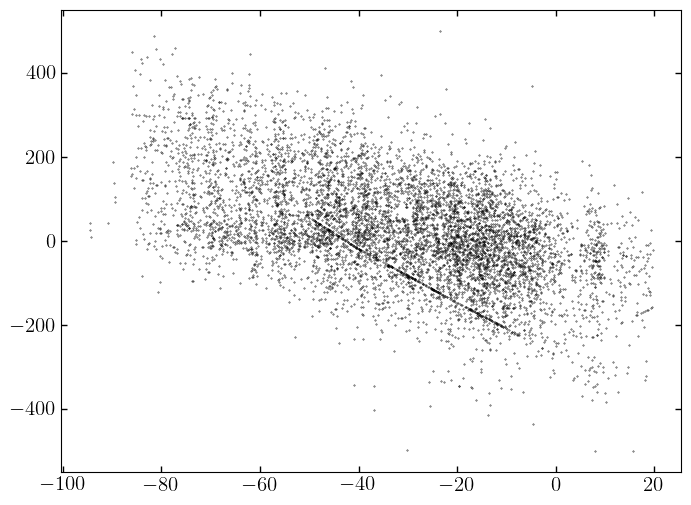

In [192]:
plt.scatter(run_data['phi1'], stream_bkg_svi_results.params['mixture:modeldata_auto_loc'][:,4], s=0.1)
plt.show()

(-100.0, 20.0)

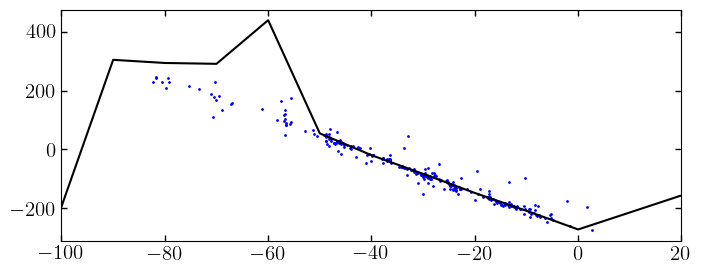

In [193]:
fig, ax = plt.subplots(1,1,figsize=(8,3), sharex=True)

ax.plot(stream_model_mm.coord_parameters['rv']['knots'], MAP_p_expanded['stream']['rv']['loc_vals'])
# ax3.plot(stream_model_mm.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
ax.scatter(stream_data['phi1'], stream_data['rv'], c='b', s=1)

ax.set_xlim(-100,20)

In [194]:
MAP_p_expanded['stream']['rv']['scale_vals']

Array([1.        , 0.10101495, 0.10075026, 0.1007119 , 0.10030135,
       0.10027893, 0.1002513 , 0.10025456, 0.10028924, 0.10022983,
       0.10080676, 0.10097956, 0.10137315], dtype=float64)

(-100.0, 20.0)

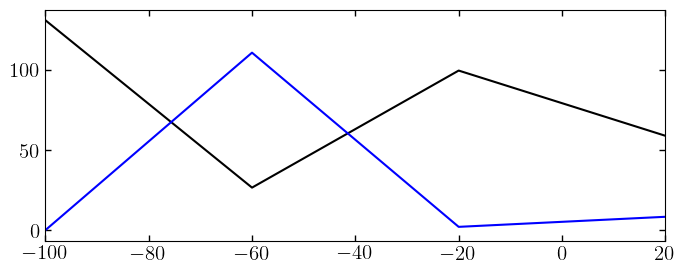

In [200]:
fig, ax = plt.subplots(1,1,figsize=(8,3), sharex=True)

ax.plot(bkg_model_mm.coord_parameters['rv']['knots'], MAP_p_expanded['background']['rv']['scale_vals'][0])
ax.plot(bkg_model_mm.coord_parameters['rv']['knots'], MAP_p_expanded['background']['rv']['scale_vals'][1])
# ax3.plot(stream_model_mm.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
# ax.set_ylim(0,0.2)

ax.set_xlim(-100,20)

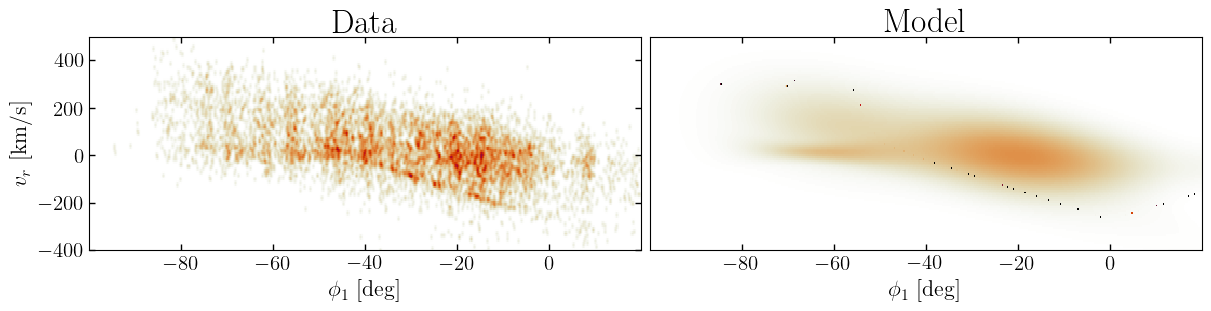

In [178]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)

plot_data_projections(
    data=only_rv_run_data,
    grids=plot_grids,
    axes=ax1,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

stream_bkg_mm.plot_model_projections(ndata=len(run_data0_['rv'][run_data0_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'rv')],
                          pars=MAP_p_expanded, axes=ax2, label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))



ax2.yaxis.set_visible(False)
ax2.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)

# plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

In [179]:
MAP_p_expanded

{'background': {'phi1': {'mixing_distribution': Array([2.19517586e-07, 2.90128103e-01, 7.08797676e-01, 1.07400110e-03],      dtype=float64),
   'scales': Array([ 2.50065374, 13.058601  , 16.52950078,  2.48453774], dtype=float64)},
  'rv': {'loc_vals': Array([[  80.12927034,    9.39596504,  -51.97974143, -377.1595923 ],
          [ 218.07047753,  126.55074131,    8.78898909,  -51.83038785]],      dtype=float64),
   'mixing_distribution': Array([0.1916296, 0.8083704], dtype=float64),
   'scale_vals': Array([[131.13733815,  26.73332983,  99.72269252,  59.0622903 ],
          [  0.18303014, 110.88276546,   2.26546564,   8.53794094]],      dtype=float64)}},
 'stream': {'phi1': {'mixing_distribution': Array([2.86611499e-06, 2.02685935e-06, 2.95146896e-06, 1.51261171e-02,
          8.72557341e-03, 2.55880751e-02, 2.03285626e-02, 5.27881201e-06,
          5.45229009e-06, 1.72147594e-02, 2.01470722e-02, 1.86140355e-01,
          6.58761358e-02, 7.50859465e-02, 1.36378716e-01, 1.00204673e-01,
  